# insert titel of code

generic intro text

## imports

### Libraries

In [3]:
import pickle
import torch
import matplotlib.pyplot as plt
import argparse

### Custom scripts

In [4]:
# from scripts.args import *
from scripts.base_model.preprocessing import *
from scripts.base_model.train_base import *
from scripts.base_model.models import *
from scripts.evaluation.eval_model import *
from scripts.evaluation.get_results import *
from scripts.CEF_model.CEF_model import *
from scripts.CEF_model.train_CEF import *


## Args

### args preprocessing

In [5]:
def arg_parser_preprocessing():
    parser = argparse.ArgumentParser()
    parser.add_argument("--sentires_dir", dest="sentires_dir", type=str, default="data/input_data/reviews_with_features.txt", 
                        help="path to sentires data")
    parser.add_argument("--review_dir", dest="review_dir", type=str, default="data/input_data/reviews_Electronics_5_filtered.json", 
                        help="path to original review data")
    parser.add_argument("--user_thresh", dest="user_thresh", type=int, default=20, 
                        help="remove users with reviews less than this threshold")
    parser.add_argument("--item_thresh", dest="item_thresh", type=int, default=20, 
                        help="remove users with reviews less than this threshold")
    parser.add_argument("--sample_ratio", dest="sample_ratio", type=int, default=2, 
                        help="the (negative: positive sample) ratio for training BPR loss")
    parser.add_argument("--test_length", dest="test_length", type=int, default=5, 
                        help="the number of test items")
    parser.add_argument("--val_length", dest="val_length", type=int, default=1, 
                        help="the number of val items")
    parser.add_argument("--neg_length", dest="neg_length", type=int, default=100, help="# of negative samples in evaluation")
    parser.add_argument("--save_path", dest="save_path", type=str, default="data/preprocessed_data/Dataset.pickle", 
                        help="The path to save the preprocessed dataset object")
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=False, 
            help="Wether or not to use a stored dataset object")
    return parser.parse_known_args()

### args Train base model

In [6]:
def arg_parser_training():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--batch_size", dest="batch_size", type=int, default=128)
    parser.add_argument("--lr", dest="lr", type=float, default=0.01)
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--gpu", default=False)
    parser.add_argument("--weight_decay", default=0., type=float) # not sure whether to use
    parser.add_argument("--model_path", dest="model_path", type=str, default="data/models/model.model", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=1)
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=True, 
            help="Wether or not to use a stored model object")
    return parser.parse_known_args()

### arg CEF

In [7]:
# todo
def arg_parser_training():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--ld", default=1, type=float) # not sure whether to use
    parser.add_argument("--lr", dest="lr", type=float, default=0.01)
    parser.add_argument("--model_path", dest="model_path", type=str, default="data/models/CEF_model.model", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=1)
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=True, 
            help="Wether or not to use a stored model object")
    return parser.parse_known_args()

### args get results

In [8]:
def arg_parser_results():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--remove_size", dest="remove_size", type=int, default=50)
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--output_path", dest="output_path", type=str, default="results/result dicts/", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=1)
    parser.add_argument("--beta", dest="beta", type=int, default=0.1 )
    return parser.parse_known_args()

## Basemodel

In [3]:
device = "cpu"

### Preprocessing

In [9]:
# get the arguments for preprocessing
preprocessing_args, unkown = arg_parser_preprocessing()

# load dataset if the dataset exist
dataset_path = preprocessing_args.save_path
if preprocessing_args.use_pre:
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset = preprocessing(preprocessing_args)
    with open(dataset_path, "wb") as f:
            pickle.dump(dataset, f)

======================= sample training data =======================
# training samples : 285879
======================= sample test data =======================
# test samples : 5105


### Train base model

In [5]:
train_args, _ = arg_parser_training()
model_path = train_args.model_path
if train_args.use_pre:
    base_model = BaseRecModel(dataset.feature_num, dataset).to(device)
    base_model.load_state_dict(torch.load(model_path))
else:
    base_model = trainmodel(train_args, dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0:  training loss:  0.5512831


100%|██████████| 1/1 [02:17<00:00, 137.99s/it]

epoch 0:  training loss:  0.5512831 NDCG:  0.2589887707623413


### Results of base model

In [6]:
ndcg, f1, _ = eval_model(dataset, 5, model, device)
print(f"ndcg : {ndcg}")
print(f"f1 : {f1}")

ndcg : 0.2589887707623413
f1 : 0.23682664054848193


### CEF model

In [7]:
### stil to do.
CEF_args, _ = arg_parser_CEF()
model_path = CEF_args.model_path
if train_args.use_pre:
    CEF_model = CEF(CEF_args, dataset, base_model).to(device)
    CEF_model.load_state_dict(torch.load(model_path))
else:
    CEF_model = train_delta(CEF_args, CEF_model)

### Plot results

In [9]:
result_args, _ = arg_parser_results()
results = get_results(dataset, result_args, base_model, CEF_model)

0.0


KeyboardInterrupt: 

In [11]:
def plot_results(results):
    for method in results:
        result = results[method]
        plt.scatter(result["lt"], result["ndcg"], label = method)
    
    plt.xlabel("long tail rate")
    plt.ylabel("NDCG")
    plt.legend()
    plt.show()

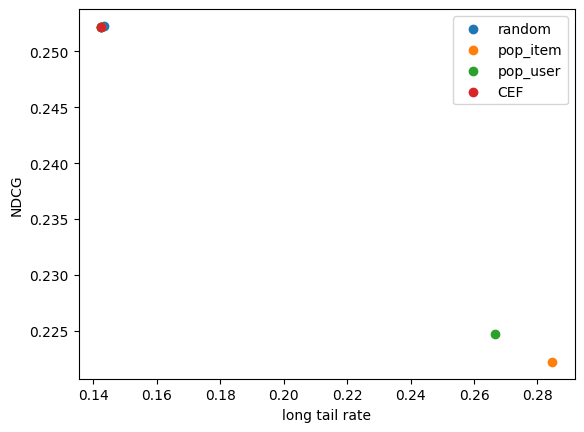

In [12]:
plot_results(results)